In [4]:
import numpy as np, pandas as pd
import torch, os, logging

from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

from preprocessing import load_dataset, normalize

# Set up Python logging
logging.basicConfig(level=logging.ERROR)

# Create a log directory with a timestamp to keep different runs separate
logdir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
os.makedirs(logdir, exist_ok=True)
writer = SummaryWriter(logdir)

pd.set_option('display.precision', 20)

# torch.manual_seed(1234)
torch.autograd.set_detect_anomaly(True)

if __name__ == "__main__":

    # Load Data (change path if needed)
    path = ["airFoil2D_SST_31.677_-0.742_2.926_5.236_5.651"]
    train_data, len_list = load_dataset(path, 
                                       n_random_sampling = 0
                                       )

    Uinf, alpha, gamma_1, gamma_2, gamma_3 = float(path[0].split('_')[2]), float(path[0].split('_')[3])*np.pi/180, float(path[0].split('_')[4]), float(path[0].split('_')[5]), float(path[0].split('_')[6])
    print(f"Uinf: {Uinf}, alpha: {alpha}")
    
    u_inlet, v_inlet = np.cos(alpha)*Uinf, np.sin(alpha)*Uinf
    
    df_train_input = pd.DataFrame(train_data[0].x_train, columns=["x", "y", "sdf", "x_n", "y_n"])
    df_train_target = pd.DataFrame(train_data[0].y_train, columns=["u", "v", "p", "nut"])
    df_train = pd.concat([df_train_input, df_train_target], axis=1) 

    df_box = df_train.iloc[len_list[0]:len_list[0]+len_list[1]+len_list[2],:]

    df = df_box[(df_box['x'] <= 4) & (df_box['x'] >= 1.5)]
    mean_variance_dict = {column: {"mean": 0.0, "var": 1.0} for i, column in enumerate(df.columns)}
        
    print("Datasets Loaded.")

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.69it/s]

Uinf: 31.677, alpha: -0.012950343049797924
Datasets Loaded.


In [5]:
from models.PIMNN_Phy_Bc import PIMNN_Phy_Bc
from plot import plot_predictions_vs_test, plot_test

# Train the model
model = PIMNN_Phy_Bc(df, mean_variance_dict, u_inlet, v_inlet, gamma_1, gamma_2, gamma_3)
if torch.cuda.device_count() > 1:
    print(f"Let's use {torch.cuda.device_count()} GPUs!")
    model = torch.nn.DataParallel(model)
    
# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

print(f"Started Training.")
model.train(501)
print(f"Finished Training.")

u layers: [8, 512, 512, 512, 512, 512, 512, 1]
v layers: [8, 512, 512, 512, 512, 512, 512, 1]
p layers: [8, 512, 512, 512, 512, 512, 512, 1]
nut layers: [8, 512, 512, 512, 512, 512, 512, 1]
Started Training.
Loading checkpoint 'path_to_checkpoint.pth'
Resuming from iteration 1
Iteration: 2
Iteration: 4
Iteration: 6
Iteration: 8
Iteration: 10
u_loss: 0.7745977640151978
v_loss: 0.0018529394874349236
p_loss: 2.3058714866638184
nut_loss: 1.1994393389613833e-06
Saved checkpoint to 'path_to_checkpoint.pth' at iteration 10
Iteration: 12
Iteration: 14


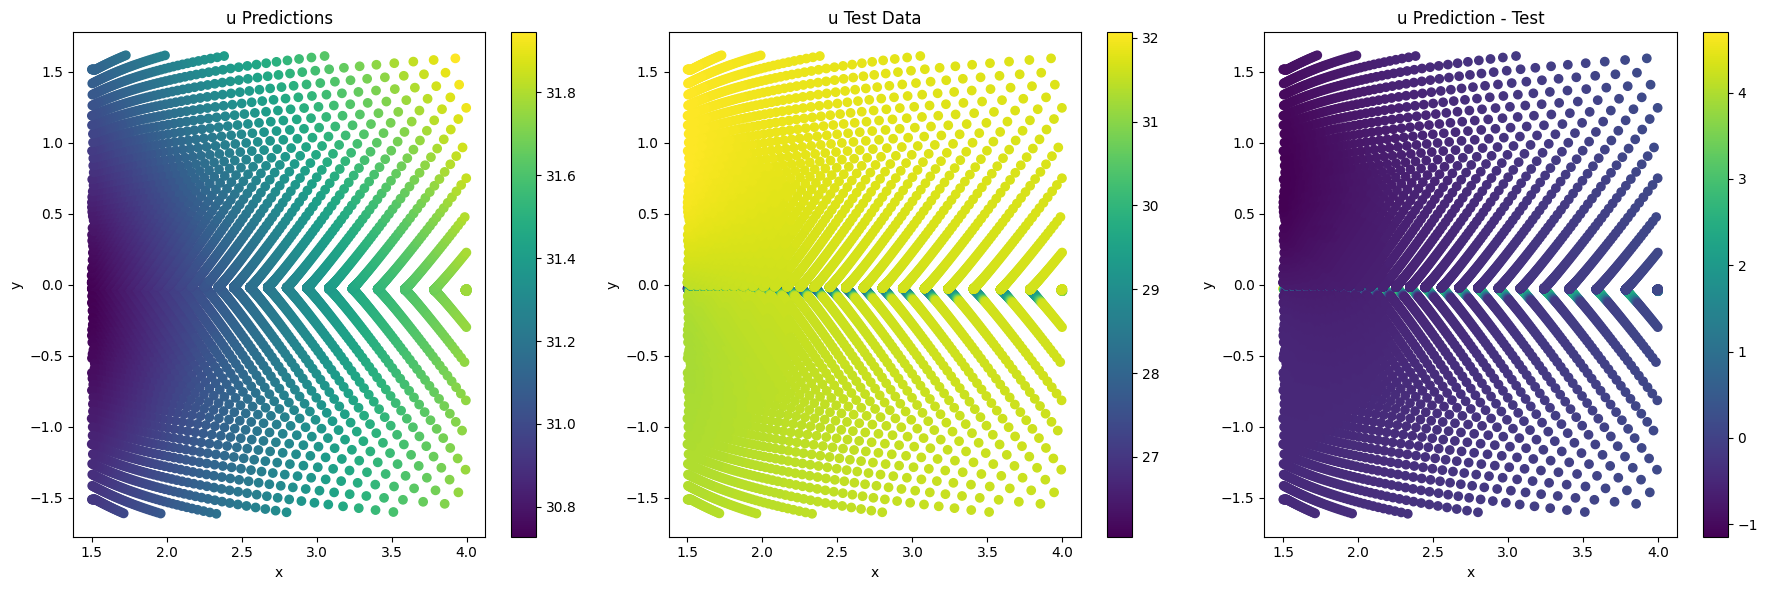

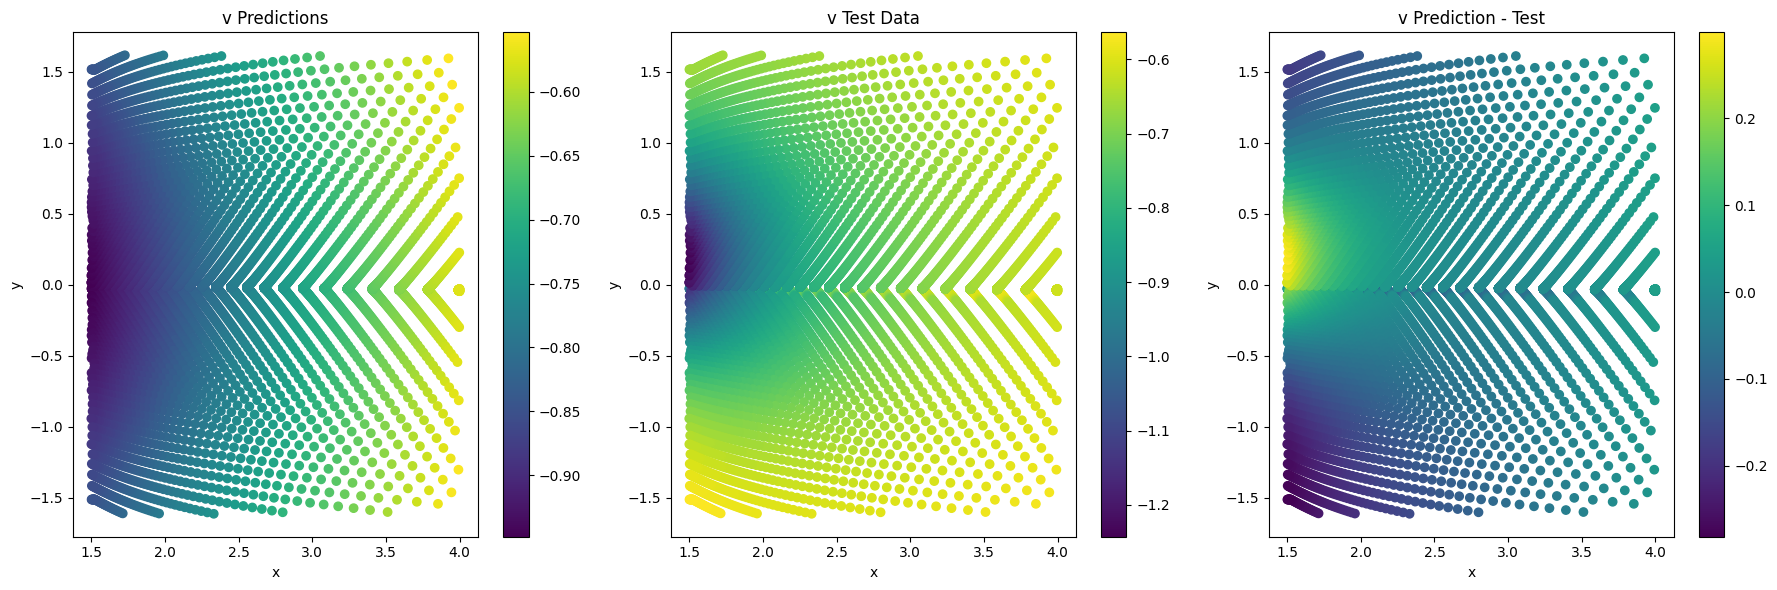

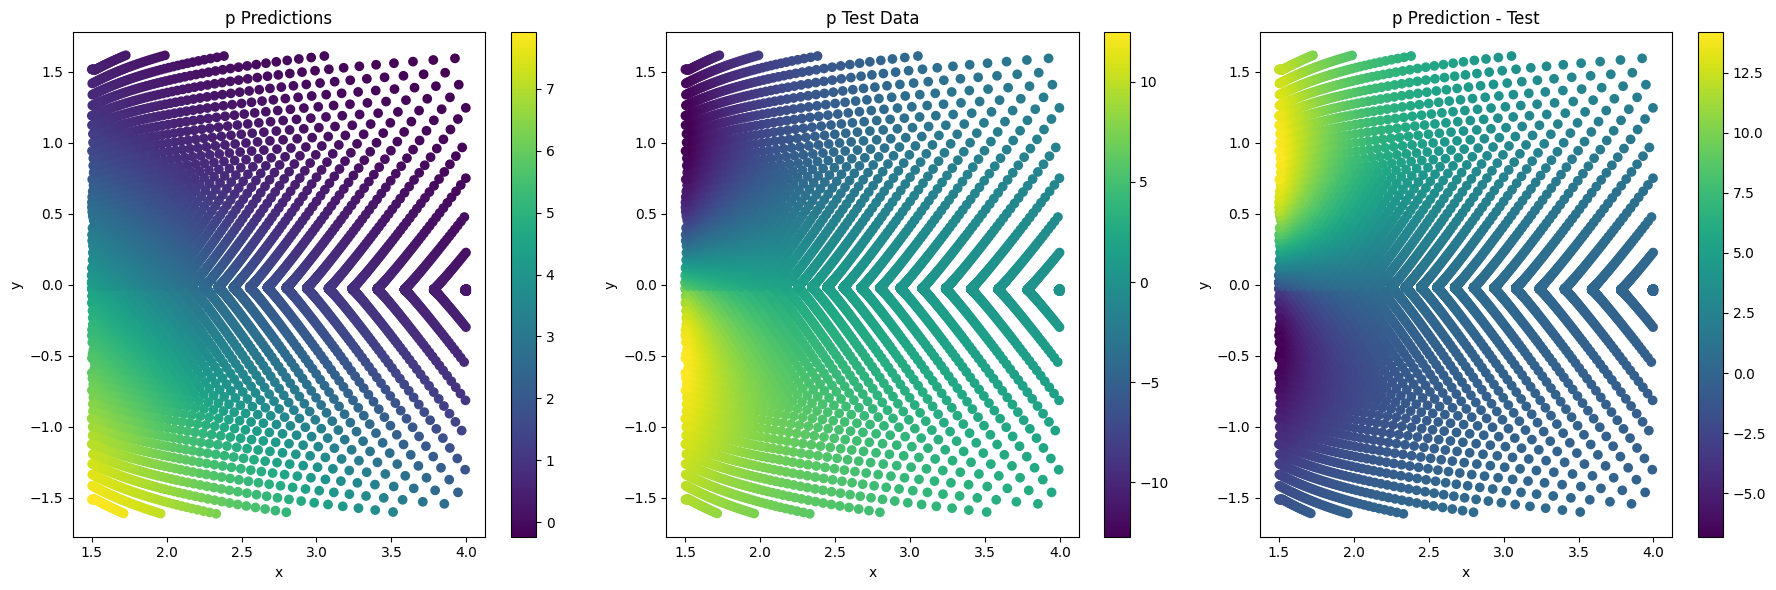

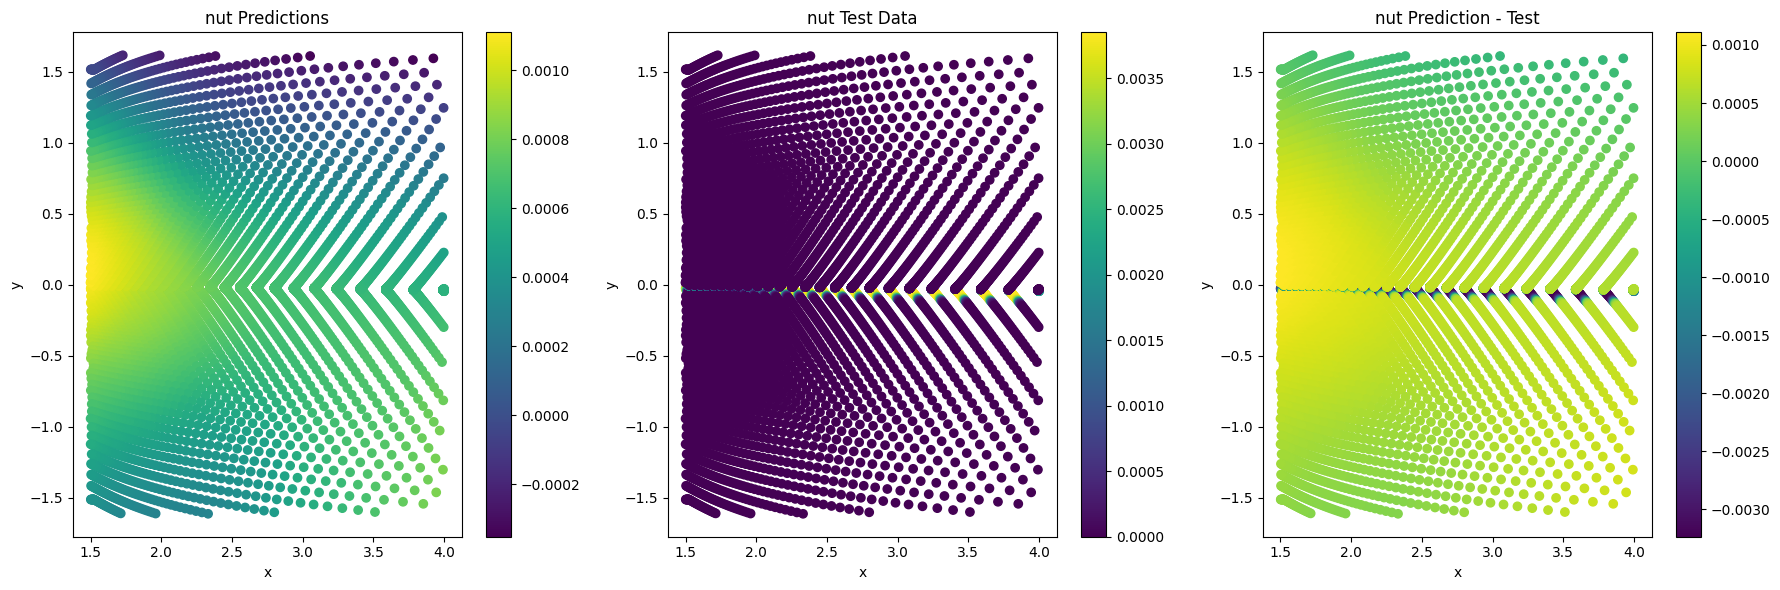

In [ ]:
# Prediction u_pred, v_pred, p_pred, nut_pred
u_pred, v_pred, p_pred, nut_pred = model.predict(df, u_inlet, v_inlet, gamma_1, gamma_2, gamma_3)

# Plotting
plot_predictions_vs_test(df['x'].astype(float).values.flatten(), df['y'].astype(float).values.flatten(), u_pred, df['u'], 'u', 'PINN_Phy_Bc')
plot_predictions_vs_test(df['x'].astype(float).values.flatten(), df['y'].astype(float).values.flatten(), v_pred, df['v'], 'v', 'PINN_Phy_Bc')
plot_predictions_vs_test(df['x'].astype(float).values.flatten(), df['y'].astype(float).values.flatten(), p_pred, df['p'], 'p', 'PINN_Phy_Bc')
plot_predictions_vs_test(df['x'].astype(float).values.flatten(), df['y'].astype(float).values.flatten(), nut_pred, df['nut'], 'nut', 'PINN_Phy_Bc')